# Modulación OFDM en Tiempo Discreto

## 1. Introducción

**Orthogonal Frequency Division Multiplexing (OFDM)** es una técnica de modulación digital que divide la información en múltiples subportadoras ortogonales, lo que permite transmitir datos a altas tasas de manera robusta ante interferencias y desvanecimientos selectivos en frecuencia. La utilización de la transformada inversa de Fourier (IFFT) permite generar la señal OFDM en el dominio del tiempo a partir de los símbolos modulados (por ejemplo, QPSK, QAM), facilitando su implementación en sistemas digitales.

En este trabajo nos enfocaremos en la implementación de la modulación OFDM en tiempo discreto, utilizando Python y bibliotecas como `NumPy` y `Matplotlib` para simular el proceso.

## 2. Transmisión OFDM en Tiempo Discreto

El sistema OFDM emplea múltiples subportadoras ortogonales para dividir el flujo de datos, permitiendo la transmisión simultánea de cada componente en distintas frecuencias. Para facilitar la comprensión del proceso de transmisión, decidimos separar el proceso de transmisión en las siguientes etapas:

### Etapa N° 1: Conversion de Datos a Simbolos

Los datos de entrada (una cadena de numeros binarios) se agrupan en bloques de longitud fija y dependiendo de la técnica de modulación utilizada (QAM en nuestro caso), cada grupo de bits se convierte en un símbolo complejo.

**Imports Necesarios**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp

**Funciones Heredadas para Plotear**

In [2]:
def plotSignal(signal, option):
#------------------------------- Transmitted I component -------------------------------
    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    
    if option == 'T':
    # Plot time domain
        plt.subplot(2,1,1)
        plt.plot(np.real(signal))
        plt.xlabel('n')
        plt.ylabel('Amplitud')
        plt.title('Componente en fase de la señal')
        plt.grid()
#------------------------------- Transmitted Q component -------------------------------
    elif option == 'Q':
        # Plot time domain
        plt.subplot(2,1,2)
        plt.plot(np.imag(signal))
        plt.xlabel('n')
        plt.ylabel('Amplitud')
        plt.title('Componente en cuadratura de la señal')
        plt.grid()
        plt.show()

def plotSpect(signal,samplingRate):
    plt.subplots(figsize=(15, 3))
    plt.grid()
    plt.title("Power Spectral Density")
    plt.psd(signal, NFFT=len(signal), Fs=samplingRate, color='C1')
    plt.show()
    
def show_fft_spectrum(signal, fs):
    N = 4096  # Número de puntos en FFT (ajustable)
    spectrum = np.fft.fft(signal, n=N)
    freqs = np.fft.fftfreq(N, d=1/fs)

    plt.figure(figsize=(12, 4))
    plt.plot(freqs / 1e3, 20 * np.log10(np.abs(spectrum)))
    plt.title("Espectro de magnitud (FFT directa)")
    plt.xlabel("Frecuencia [kHz]")
    plt.ylabel("Magnitud [dB]")
    plt.grid()
    plt.tight_layout()
    plt.show()

**Generación de Señal de Origen Binaria**

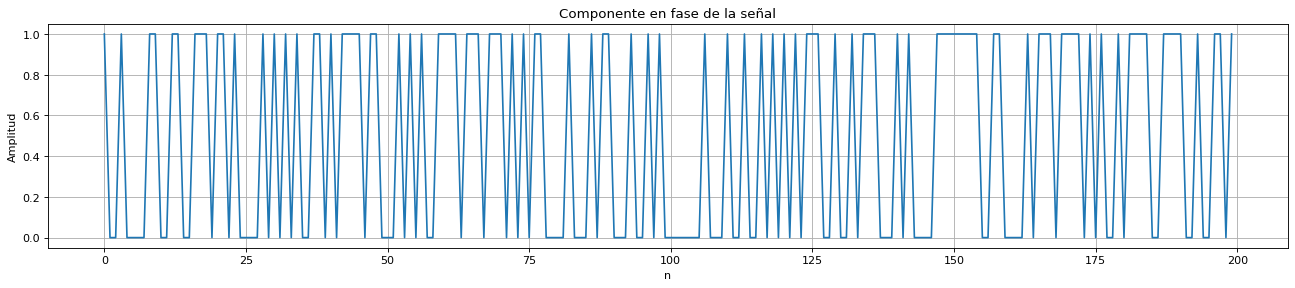

In [3]:
# Parámetros
samples = 2**10  # Cantidad de muestras

# Generación de la señal binaria aleatoria
signal = np.random.randint(0, 2, samples)

plotSignal(signal[:200], 'T')  # Plot de la componente en fase de la señal
# NOTA: No hay componente en cuadratura para una señal binaria en esta etapa

**Modulacion QAM (Quadrature Amplitude Modulation):**

Esta modulacion nos permite enviar más información a través de una sola señal, ya que se usan diferentes combinaciones de amplitudes y fases. Cuantos más niveles de amplitud y fase se utilicen, más datos se pueden transmitir en el mismo espacio de tiempo, pero también se hace más difícil para el receptor descifrar la señal si hay ruido o interferencia.

La ecuación de tiempo continuo de la función QAM es:

$$s(t) = I(t)\cdot\cos(2\pi f_ct)+Q(t)\cdot\sin(2\pi f_ct)$$

Donde:

- $I(t)$ es la componente en fase *(in-phase)* respecto a la portadora.
- $Q(t)$ es la componente en cuadratura *(quadrature)* respecto a la portadora (desfasada 90°).
- $f_c$ es la frecuencia de la portadora.

**Mapeo de la señal binaria a símbolos QAM**

<div style="display: flex; align-items: center; justify-content: flex-start;">
    <div style="flex: 0 0 250px; margin-right: 24px;">
        <img src="./../images/mapeo.png" alt="QPSK Gray Coding" width="400">
    </div>
    <div style="flex-grow: 1;">
        Para convertir los bits a símbolos, se utiliza un mapeo que agrupa los bits en pares y los asocia a puntos en el plano complejo. Optamos por un mapeo estándar de 4-QAM (Gray coding), donde cada par de bits se convierte en un símbolo complejo siguiendo, en nuestro caso, un orden de izquierda a derecha y de arriba hacia abajo. A la izquierda adjuntamos una representación gráfica de este mapeo:
    </div>
</div>

In [4]:
def qam_mapping(signal):
    
    if len(signal) % 2 != 0:
        signal = np.append(signal, 0) # si es impar le agrega un 0 al final

    # Diccionario de Mapeo QAM
    mapping = {
        (0, 0) : -1 + 1j,
        (0, 1) : 1 + 1j,
        (1, 1) : 1 - 1j,
        (1, 0) : -1 - 1j
    }

    symbols = []
    
    # Agrupar bits en pares y mapear a símbolos
    for i in range(0, len(signal), 2):
        symbols.append(mapping[signal[i], signal[i+1]])

    return np.array(symbols)

Tamaño de la Hipótesis: 512


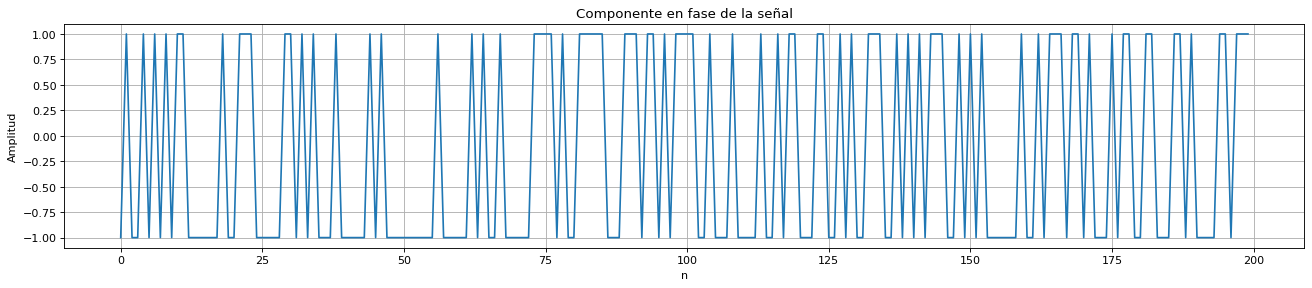

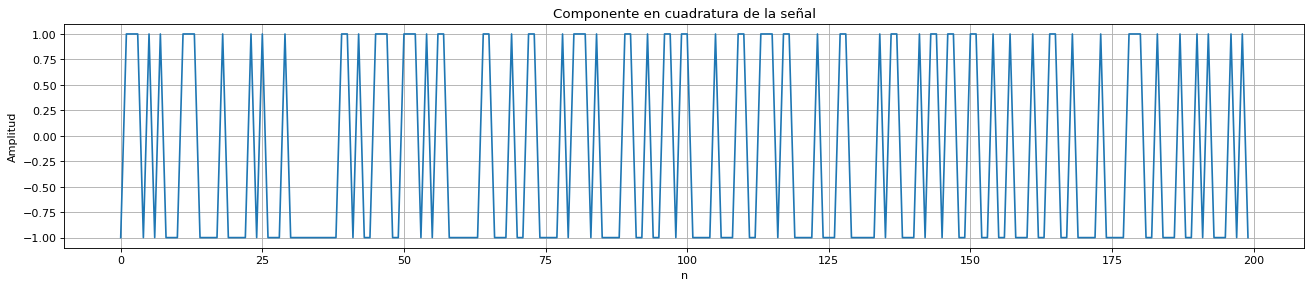

In [7]:
# Generación de Hipótesis de la señal QAM
hypothesis = qam_mapping(signal)

print("Tamaño de la Hipótesis:", len(hypothesis))
plotSignal(hypothesis[:200], 'T')  # Plot de la componente en fase de la señal QAM
plotSignal(hypothesis[:200], 'Q')  # Plot de la componente en cuadratura de la señal QAM

### Etapa N°2: Distribución de Símbolos en Subportadoras

Esta etapa consiste en distribuir cada símbolo complejo generado en la etapa anterior en diferentes subportadoras ortogonales. El objetivo es aprovechar el uso de multiples portadoras para transmitir la informacion de manera eficiente.

- **Asignacion de subportadoras:** Los simbolos se agrupan en bloques de longitud $N$, donde $N$ representa el numero de subportadoras.
- **Distribucion en frecuencia:** Cada simbolo se asocia a una subportadora de frecuencia diferente. Esto significa que si tenemos un ancho de banda total de $B$, el espaciado entre subportadoras es $\frac{B}{N}$.

In [10]:
def subcarriers_distribution(symbols, N:int):
    # Calcular la cantidad necesaria de padding para que la cantidad de símbolos sea múltiplo de N
    padding = (-len(symbols)) % N
    
    if padding > 0:
        symbols = np.append(symbols, [0]*padding) # Relleno con ceros si es necesario

    # Agrupar los símbolos en bloques de N
    blocks = symbols.reshape((-1, N))
    
    return blocks

Tamaños: 128 bloques de 4 subportadoras cada uno.
Simbolos en cada subportadora:


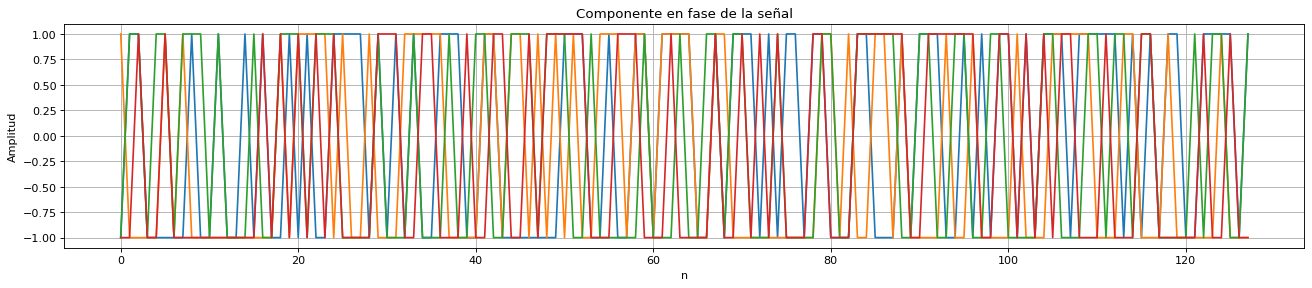

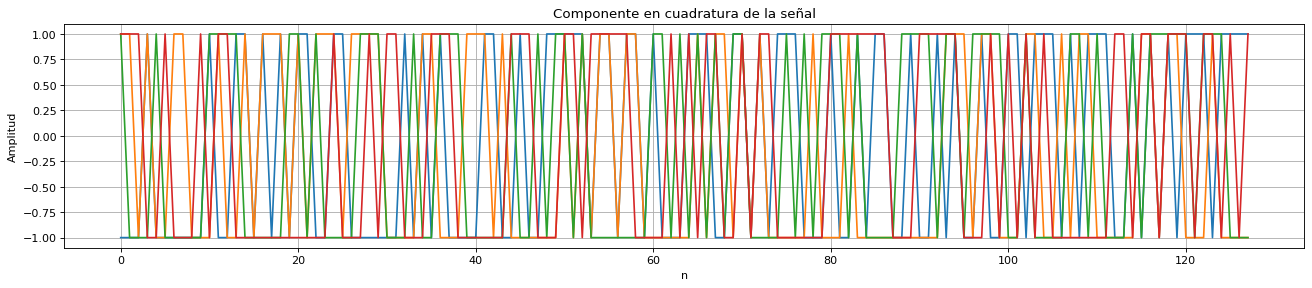

Subportadora 1: 
Cantidad de símbolos: 128


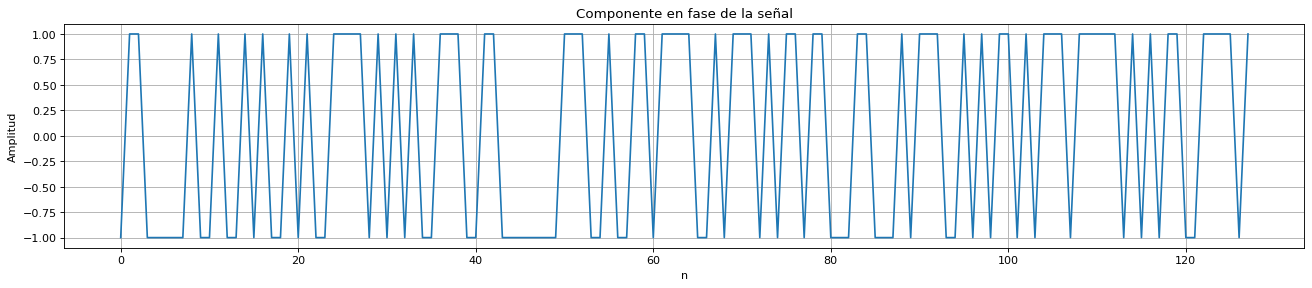

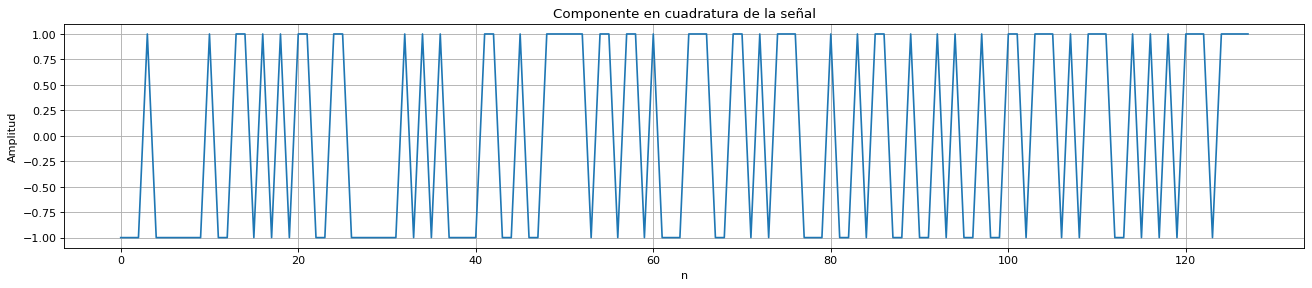

Subportadora 2: 
Cantidad de símbolos: 128


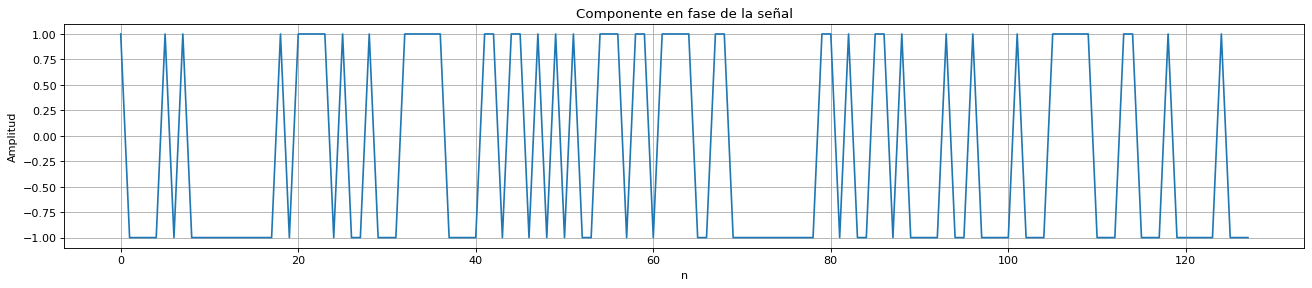

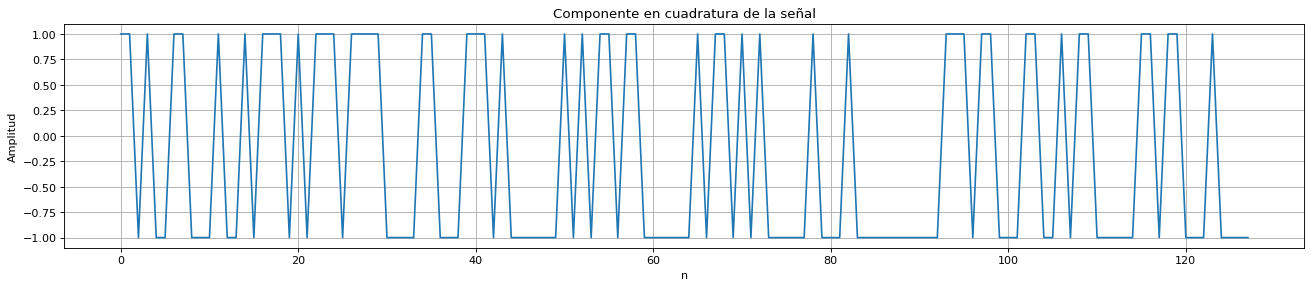

Subportadora 3: 
Cantidad de símbolos: 128


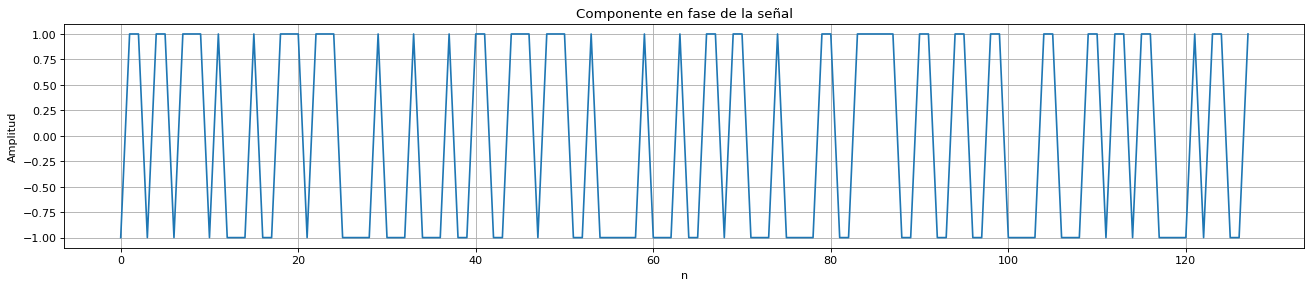

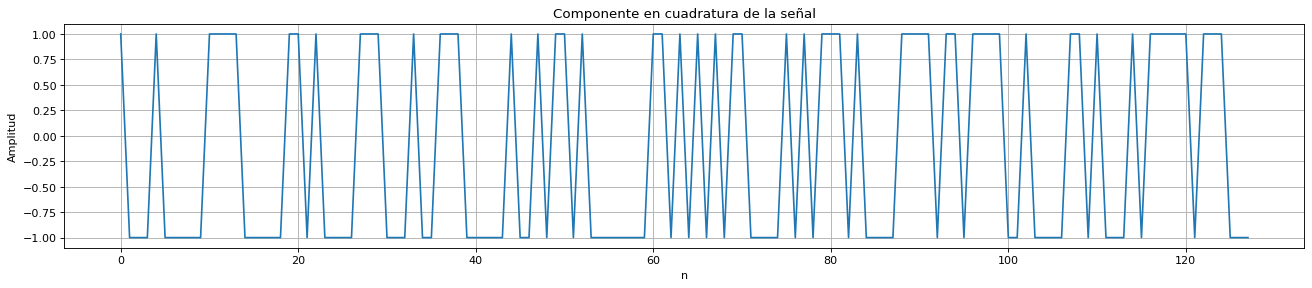

Subportadora 4: 
Cantidad de símbolos: 128


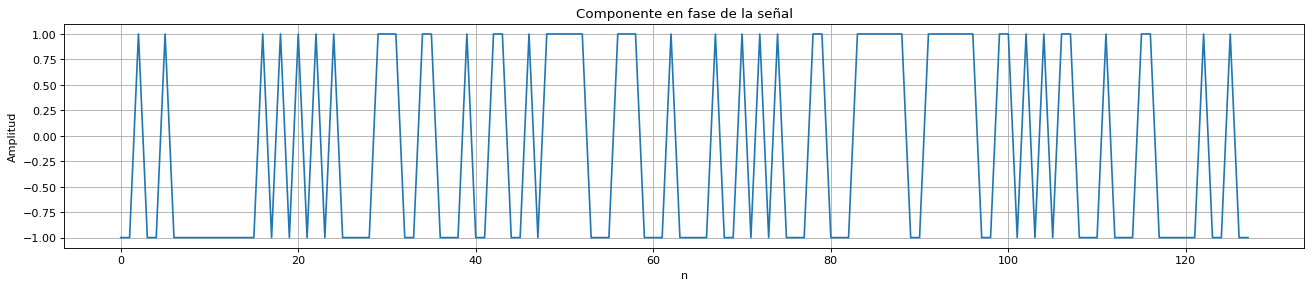

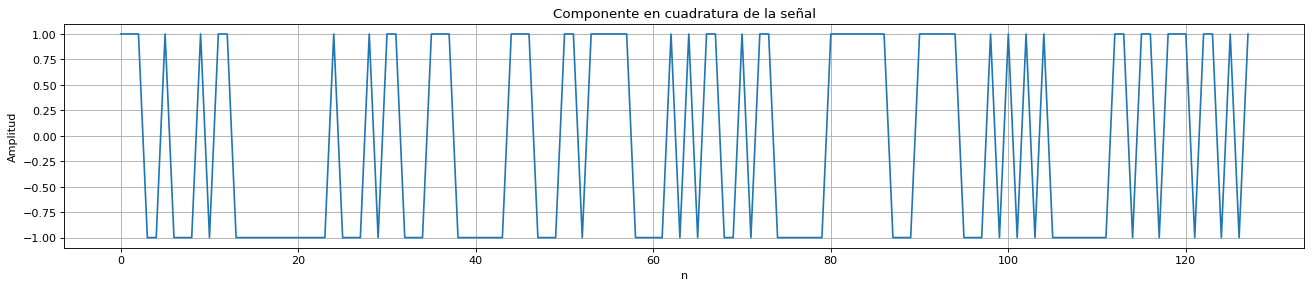

In [12]:
N = 4 # Número de subportadoras

symbol_blocks = subcarriers_distribution(hypothesis, N)

print("Tamaños:", len(symbol_blocks), "bloques de", N, "subportadoras cada uno.")

# Simbolos en cada subportadora
print(f"Simbolos en cada subportadora:")
plotSignal(symbol_blocks, 'T')
plotSignal(symbol_blocks, 'Q')

# Simbolos en cada subportadora
for sub in range(N):
    print(f"Subportadora {sub+1}: \nCantidad de símbolos: {len(symbol_blocks[:, sub])}")
    plotSignal(symbol_blocks[:, sub], 'T')
    plotSignal(symbol_blocks[:, sub], 'Q')

### Etapa N°3: Modulacion OFDM mediante IFFT.

Se aplica la **Transformada Inversa de Fourier Discreta** a cada bloque de simbolos, para obtener la señal en dominio temporal.

La señal transmitida en tiempo discreto se expresa como el resultado de la IFFT aplicada a los símbolos modulados y separados en subportadoras:

$$s(n)=\sum_{k=0}^{N-1}{X_k\cdot e^{\frac{j2\pi kn}{N}}}$$

Donde:

- $X_k$ es el simbolo modulado (cada par dentro del bloque)
- $N$ es el numero total de portadoras.
- $n$ es la cantidad de bloques.

>[!NOTE] Cada símbolo OFDM se procesa por separado. Aún no se ha generado la secuencia continua completa que será transmitida.

In [13]:
def apply_ifft(blocks):
    # Aplica la IFFT a cada bloque de símbolos
    time_domain_signals = np.fft.ifft(blocks, axis=1) # axis=1 -> cada bloque individual

    return time_domain_signals # Señal en dominio temporal

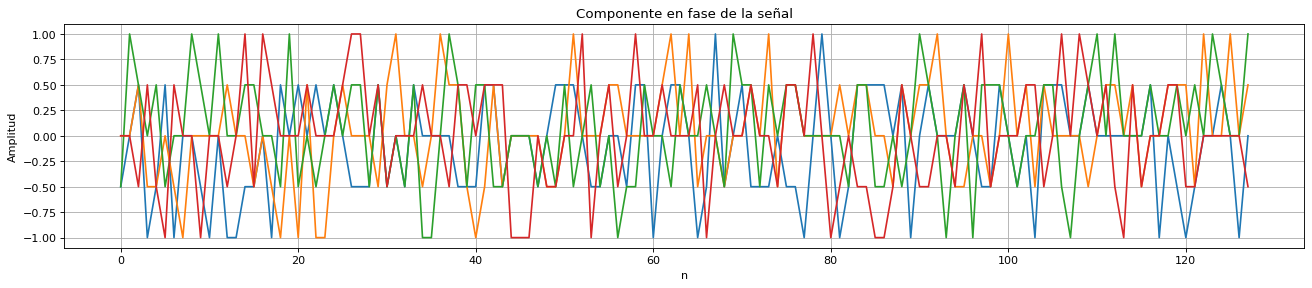

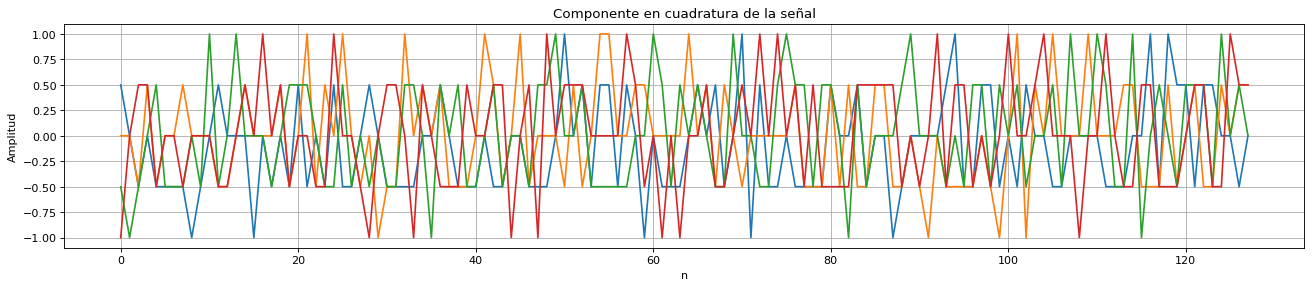

In [14]:
# IFFT Aplicada a cada bloque de símbolos
ofdm_signal = apply_ifft(symbol_blocks)

plotSignal(ofdm_signal, 'T')  # Plot de la componente en fase de la señal OFDM
plotSignal(ofdm_signal, 'Q')  # Plot de la componente en cuadratura

### Etapa N°4: Adición del Prefijo Cíclico (CP)

Para mitigar la *Interferencia Inter-Símbolo (ISI)* generada por la dispersión en canales con multitrayectoria, se incorpora un **Prefijo Cíclico (CP)** al inicio de cada símbolo OFDM.

Este prefijo es una copia de las últimas muestras del símbolo OFDM en el dominio temporal. Al repetir esta sección, se preserva la ortogonalidad entre subportadoras durante la convolución con el canal, facilitando la recuperación del símbolo en recepción.

Proceso:

- Se seleccionan los últimos $L$ puntos del símbolo OFDM (generalmente, $L \geq \text{duración del canal}$).
- Se anteponen al símbolo original, formando un nuevo bloque de longitud $N + L$.

>[!NOTE] Esta técnica convierte la convolución lineal con el canal en una convolución circular, lo que permite una recuperación simple en el receptor mediante FFT.

In [15]:
def add_prefix(ofdm_symbols, prefix_length):
    # Utiliza las últimas muestras de cada símbolo
    prefix = ofdm_symbols[:, -prefix_length:]
    
    # Concatenar el prefijo cíclico al inicio de cada símbolo OFDM
    symbols_with_cp = np.concatenate((prefix, ofdm_symbols), axis=1)
    
    return symbols_with_cp

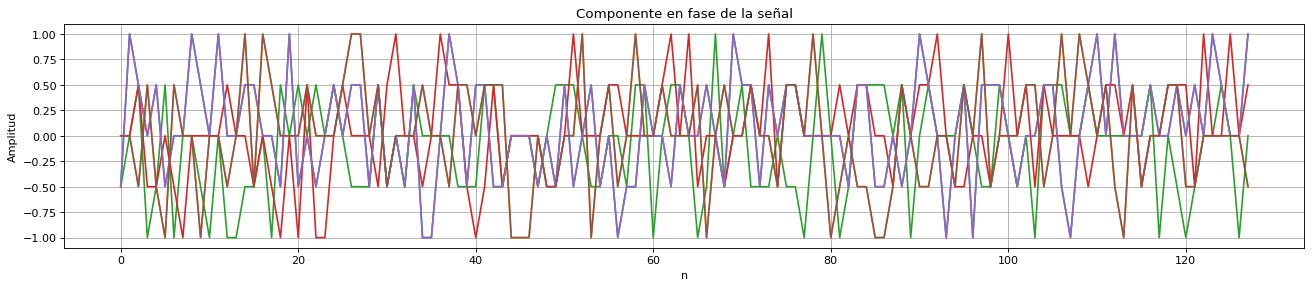

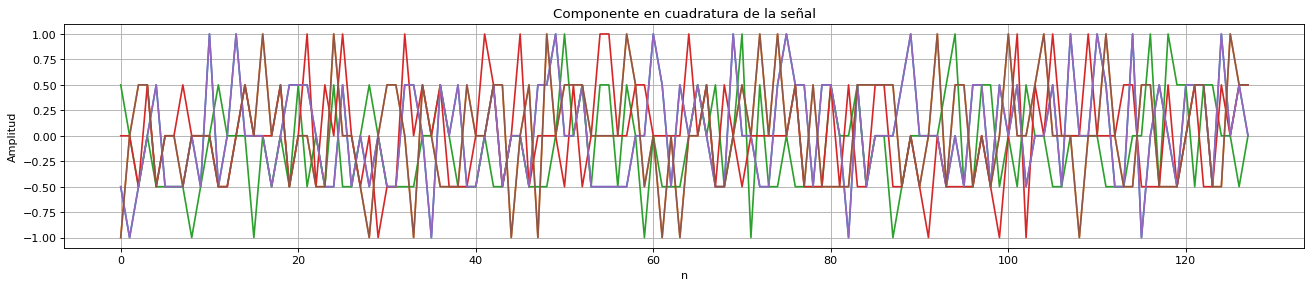

In [16]:
prefix = 2 # Tamaño del prefijo cíclico

ofdm_signal_prefixed = add_prefix(ofdm_signal, prefix)

plotSignal(ofdm_signal_prefixed, 'T')  # Plot de la componente en fase de la señal OFDM con prefijo cíclico
plotSignal(ofdm_signal_prefixed, 'Q')  # Plot de la componente en cuadratura de la señal OFDM con prefijo cíclico

### Etapa N°5: Serialización de la señal OFDM

Una vez añadidos los prefijos cíclicos, cada símbolo OFDM tiene una longitud de $N + L$, donde:

- $N$: número de subportadoras.
- $L$: longitud del prefijo cíclico.

La serialización consiste en concatenar todos los símbolos OFDM en una única secuencia de tiempo, que luego será enviada por el canal físico.

In [17]:
def serialization(symbols_with_cp):
    return symbols_with_cp.flatten()

Tamaño de la señal OFDM transmitida: 768


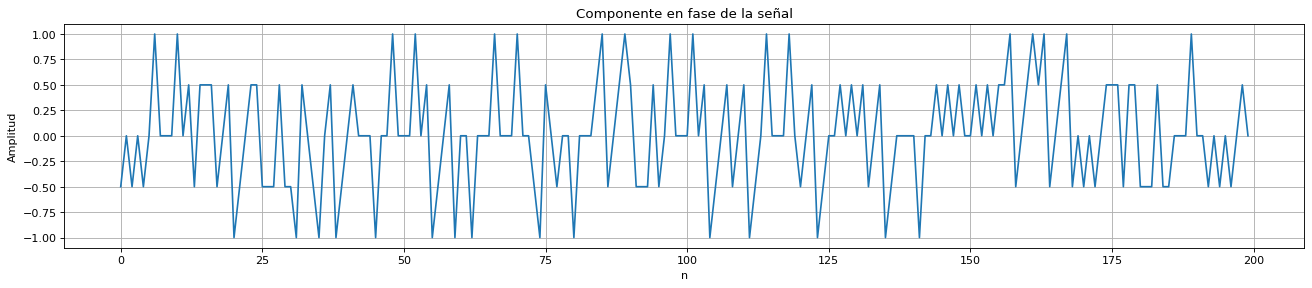

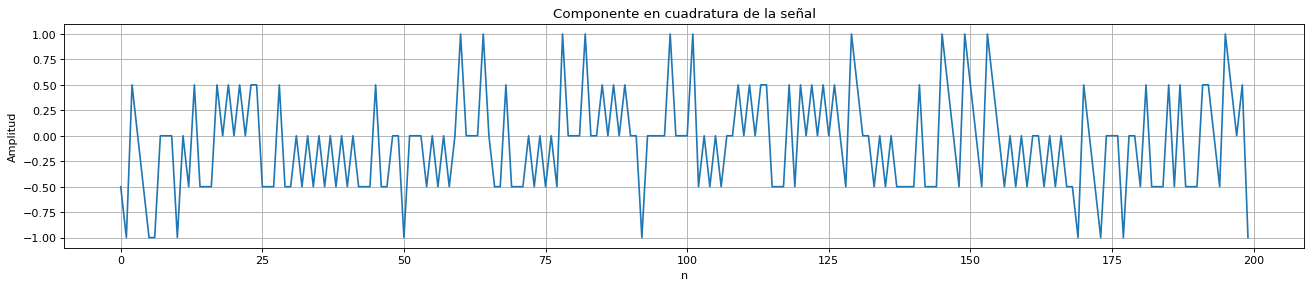

In [18]:
# Serialización de la señal OFDM con prefijo cíclico
tx_signal = serialization(ofdm_signal_prefixed)

# Plot de la señal OFDM transmitida
print("Tamaño de la señal OFDM transmitida:", len(tx_signal))
plotSignal(tx_signal[:200], 'T')  # Componente en fase
plotSignal(tx_signal[:200], 'Q')  # Componente en cuadratura

### Etapa N°6: Modulación en Banda Pasante (Modulación en Cuadratura)

Una vez serializada la señal OFDM, aún está centrada en 0 Hz (banda base). Por ende no podemos observar su espectro de frecuencia. Para transmitirla sobre una frecuencia de radio o intermedia, se realiza una modulación en cuadratura. Se modula la parte real sobre una portadora coseno, y la parte imaginaria sobre una portadora seno desfasada. Esto preserva toda la información compleja del símbolo original.

Expresión matemática:

$$s_{\text{pasante}}(t)=\Re\{s(t)\}\cdot\cos(2\pi f_c t) + \Im\{s(t)\}\cdot\sin(2\pi f_c t)$$

$$s_{\text{real}}(t)=\Re\{s(t)\} \cdot \cos(2\pi f_c t) - \Im\{s(t)\} \cdot \sin(2\pi f_c t)$$

Donde:

- $s(t)$ es la señal OFDM en banda base.
- $\Re\{s(t)\}$ es la componente en fase (real) de la señal OFDM.
- $\Im\{s(t)\}$ es la componente en cuadratura (imaginaria) de la señal OFDM.
- $f_c$ es la frecuencia de la portadora.

>**NOTA:** Una vez hecha la modulación en banda pasante, la señal compleja se transforma en una señal real, lista para ser transmitida físicamente por una antena o un cable.

In [19]:
def modulate_bandpass(signal_baseband, fs, fc):
    # Creación del vector de tiempo
    t = np.arange(len(signal_baseband)) / fs
    
    carrier_cos = np.cos(2 * np.pi * fc * t)
    carrier_sin = np.sin(2 * np.pi * fc * t)

    bandpass_signal = np.real(signal_baseband) * carrier_cos - np.imag(signal_baseband) * carrier_sin
    
    return bandpass_signal

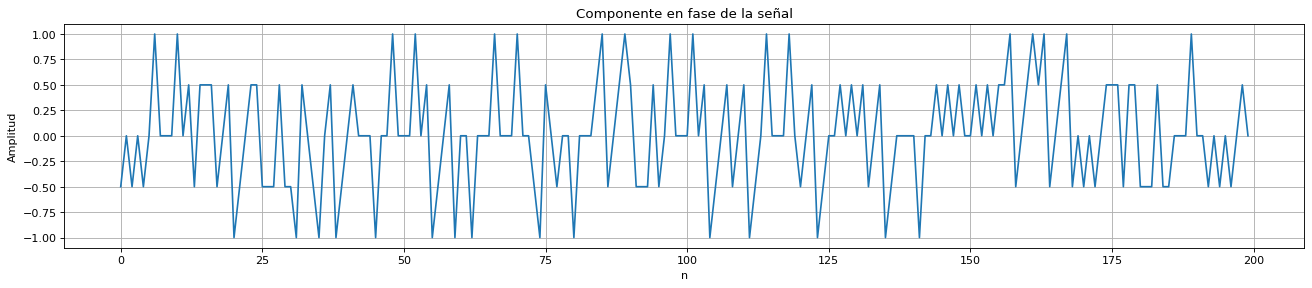

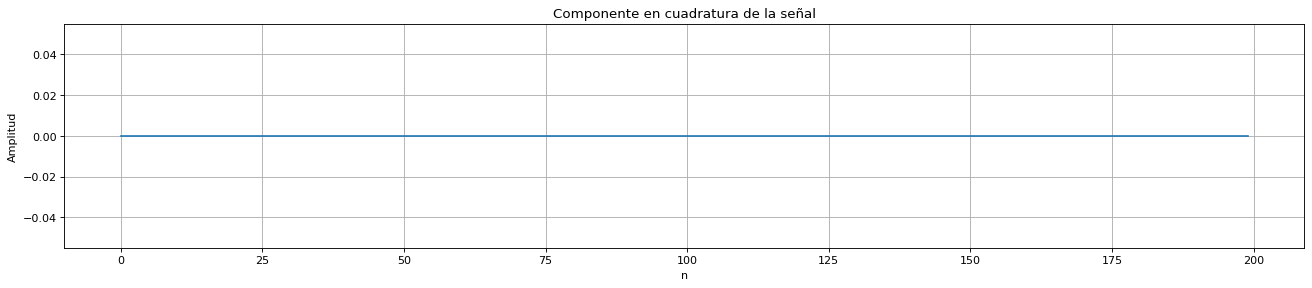

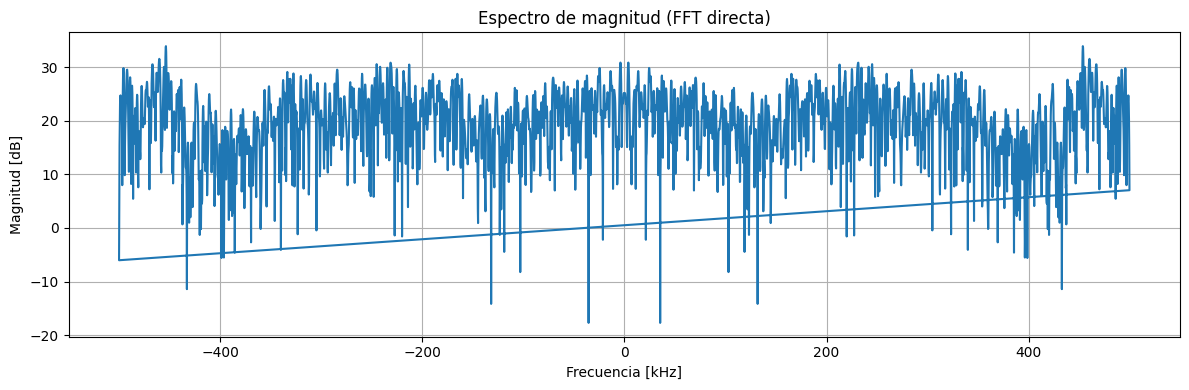

In [20]:
fs = 1e6   # Frecuencia de muestreo: 1 MHz
fc = 2e6   # Portadora: 2 MHz

tx_bandpass = modulate_bandpass(tx_signal, fs, fc)

# Plot de la señal OFDM modulada en banda pasante
plotSignal(tx_bandpass[:200], 'T')
plotSignal(tx_bandpass[:200], 'Q')

# Mostrar espectro de magnitud
show_fft_spectrum(tx_bandpass, fs)
